In [1]:
import pandas as pd
import time
import datetime
from datetime import datetime as dt
from datetime import date, timedelta
import matplotlib.pyplot as plt
import numpy as np
from dateutil.parser import parse

In [2]:
filePath = './Plants_of_me.csv'  # repalce with your own file path

In [3]:
def getMetaData(filePath):
    """transfer csv mate data to dataframe"""
    df = pd.read_csv(filePath)
    return df

df = getMetaData(filePath)
df.head(5)

,Start Time,End Time,Tag,Note,Tree Type,Is Success
0,2019-01-13T10:43:26.000+0800,2019-01-13T11:57:41.000+0800,未设定,NaN,雪松,True
1,2019-01-13T13:00:31.000+0800,2019-01-13T14:11:13.000+0800,未设定,NaN,雪松,True
2,2019-01-13T14:21:06.000+0800,2019-01-13T15:31:12.000+0800,未设定,NaN,雪松,True
3,2019-01-13T15:45:21.000+0800,2019-01-13T16:48:00.000+0800,未设定,NaN,雪松,False
4,2019-01-13T18:00:23.000+0800,2019-01-13T19:00:58.000+0800,未设定,NaN,雪松,False


In [20]:
class Time:
    localTime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())  # YYYY-MM-DD hh:mm:ss
    localDate = localTime.split()[0]  # YYYY-MM-DD
    periodDict = {'week': 7, 'month': 30, 'quarter': 90, 'half a year': 180, 'year': 365}
    
    
    def getTimePeriod(self):
        # input a time period will be analysed (month as a default)
        timePeriod = input(
                    'Input a time of period that you want to analyse (Input month with ENTER)\n'
                    'ONLY week / month / quarter / half a year / year ARE SUPPORTED: '
                    ).strip() or 'month'
        if timePeriod not in Time.periodDict.keys():
            print('NameError: The Input time period Is Error, Please Input Again.')
            timePeriod = self.getTimePeriod()
        return timePeriod
    
    
    def getDateList(self, startDate: str, endDate: str) -> list:
        """get the date list between start date and end date"""
        dateList = [dt.strftime(x, '%Y-%m-%d') for x in list(pd.date_range(startDate, endDate))]
        return dateList
    
    
    def getPastDate(self, N: int):
        """Get the date before N days (base on today)"""
        pastDate = date.today() - timedelta(days = N)
        pastDate.strftime('%Y-%m-%d')  # 格式化日期
        return pastDate
    
    
    def getNearDate(self, date: str, previous=True):
        """
        Get previous/next date zero O'clock e.g. 2020-05-01 00:00:00
        :params 
            date: a str with YYYY-MM-DD format
            previous: a bool type param which can judge is previous or next day
        """
        return parse(date) - datetime.timedelta(days=1) if previous else parse(date) + datetime.timedelta(days=1)
    
    
    def getTimeInterval(self, t1: str, t2: str):
        """
        Get time interval in second / hour
        :params
            t1 t2: a str with format YYYY-MM-DDThh:mm:ss, which T is delimiter (e.g. 2019-01-14T08:00:38)
                   t1 is the previous time point, t2 is the later time point 
        """
        t1, t2 = parse(t1), parse(t2)
        return int((t2-t1).total_seconds())

    
    def second2hour(self, second):
        """
        Transfer seconds to hours with format '9.50' hours
        ref:
            https://stackoverflow.com/questions/775049/how-do-i-convert-seconds-to-hours-minutes-and-seconds
        :params second: nums
        :return floatHours: float format hour 
        """
        HMS = str(datetime.timedelta(seconds=second))
        hours, minutes = HMS.split(':')[0], HMS.split(':')[1]
        floatHours = float(hours + '.' + minutes)
        return round(floatHours, 2)  # two decimal places

In [21]:
# input analysis time period 
t = Time()
timePeriod = t.getTimePeriod()
print(timePeriod)

Input a time of period that you want to analyse (Input month with ENTER)
ONLY week / month / quarter / half a year / year ARE SUPPORTED: a
NameError: The Input time period Is Error, Please Input Again.
Input a time of period that you want to analyse (Input month with ENTER)
ONLY week / month / quarter / half a year / year ARE SUPPORTED: a
NameError: The Input time period Is Error, Please Input Again.
Input a time of period that you want to analyse (Input month with ENTER)
ONLY week / month / quarter / half a year / year ARE SUPPORTED: a
NameError: The Input time period Is Error, Please Input Again.
Input a time of period that you want to analyse (Input month with ENTER)
ONLY week / month / quarter / half a year / year ARE SUPPORTED: month
month


In [22]:
class Chart:
    def pltChart(self, dates: list, values: list, chartType='line', xLabel='Date', yLabel=None, title=None):
        """
        Plot line/bar chart
        params:
            dates: a list of date with format YYYY-MM-DD
            values: a list of values depends on what content want to plot
            xLabel: x-corrdinate label
            yLabel: y-corrdinate label
            title: the line chart title
            chartType: (str) line OR bar
        """
        if len(dates[0].split('-')) > 2:
            dates = [''.join(day.split('-')[1:]) for day in dates]  # re-format YYYY-MM-DD to MMDD 

        X, Y = dates, values
        plt.figure(figsize=(15,10))  # TODO: auto size
        plt.plot(X, Y) if chartType == 'line' else plt.bar(X, Y)
        plt.title(title)
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)

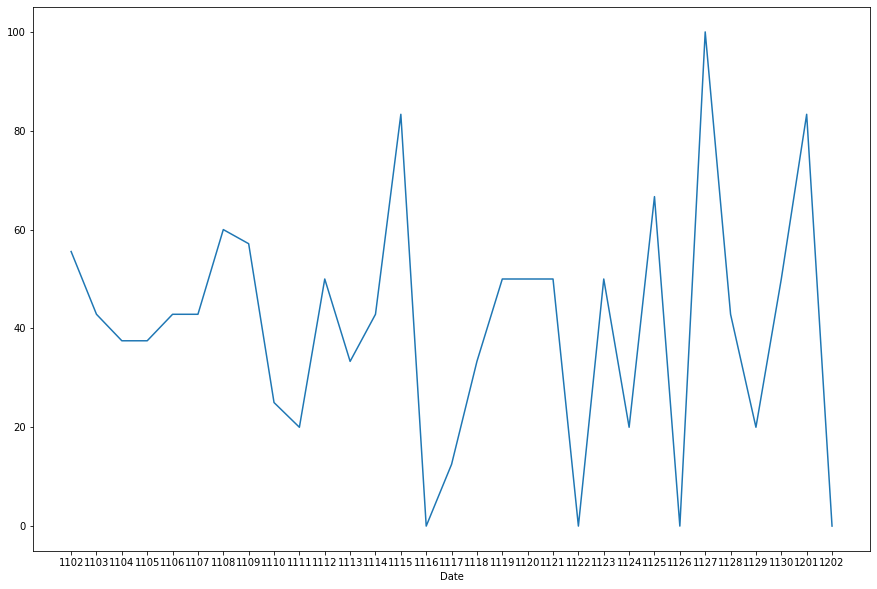

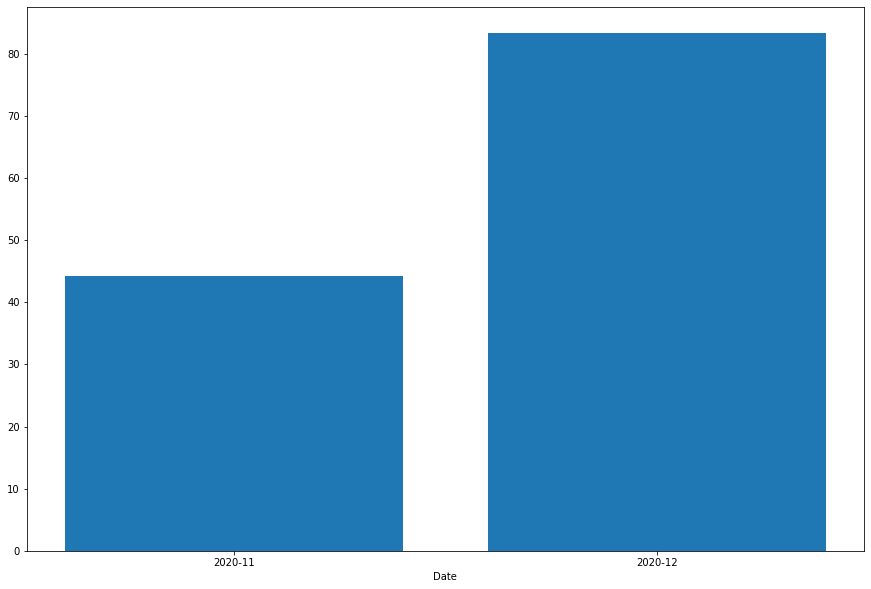

In [23]:
class SuccessAnalysis:
    def __init__(self, df):
        self.df = df
        self.t = Time()
    
    
    def successInDay(self, date=Time.localDate, showResult=False):
        """
        success number / rate in a sepcific day
        :params 
            date: a date with format YYYY-MM-DD, nowtime as the default
            showResult: (bool) whether print result
        :return 
            countTree: (int) the number of trees in the day
            len(dfSuccessTree): (int) the number of successful trees in the day
            successRate: (float) success rate in the day
        """
        boolInDate = self.df['Start Time'].str.contains(date)  # transfer to bool
        dfInDate = self.df[boolInDate]  # get all row meet the date condition
        
        try:
            countTree = len(dfInDate)  # eligible tree number in total
            dfSuccessTree = dfInDate.loc[dfInDate['Is Success'] == True]  # successed tree df
            successRate = round((len(dfSuccessTree) / countTree) * 100, 2)  # success rate
        
        except ZeroDivisionError:
            successRate = None
            if showResult:
                print('You do not have a tree in {}'.format(date), end = '\n\n')
        
        else:
            if showResult:
                print('In {}, there are {} trees, {} of which are successful, the success rate is {}%'
                      .format(date, countTree, len(dfSuccessTree), successRate), end = '\n\n')
            pass
        return countTree, len(dfSuccessTree), successRate if successRate else 0.0  # assign 0 for the day does not have a tree
    
    
    def successInTimePeriod(self):
        """success number / rate in a time of period"""
        periodInDays = Time.periodDict[timePeriod]
        
        pastDate = self.t.getPastDate(periodInDays)
        dateList = self.t.getDateList(pastDate, Time.localDate)
        # get cusscessful rate list correspond to dateList
        successRateList = [self.successInDay(d)[-1] for d in dateList]
        return dateList, successRateList    

    
    def monthAveSucRate(self, days: list):
        """
        Get average success rate according to month
        :params days: a list of days with format YYYY-MM-DD
        :return
            list(treeDict): a list of month
            list(treeDict.values()): a list of success rate correspond to the month 
        formula: 
            number of success in month / number of trees in month
        """
        treeDict = {}  # use a dict to count trees, format with date: [succ, total]
        for day in days:
            countTree, successTree, _ = self.successInDay(day)
            month = '-'.join(day.split('-')[:-1])
            if month not in treeDict:
                treeDict[month] = [successTree, countTree]
            else:
                treeDict[month][0] += successTree
                treeDict[month][1] += countTree
        # calculate success rate
        for key, value in treeDict.items():
            successRate = round((value[0]/value[1])*100, 2) if value[1] != 0 else 0.0
            treeDict[key] = successRate
        return list(treeDict), list(treeDict.values())  # month, success rate
        
    
        
s = SuccessAnalysis(df)
# _ = s.successInDay(date='2020-05-01',showResult=True)  # analyse a specific date success situation

days, succ = s.successInTimePeriod()
Chart.pltChart(Chart, days, succ, 'line')  # plot success rate in days

mon, succMon = s.monthAveSucRate(days)
Chart.pltChart(Chart, mon, succMon, 'bar')  # plot success rate in months

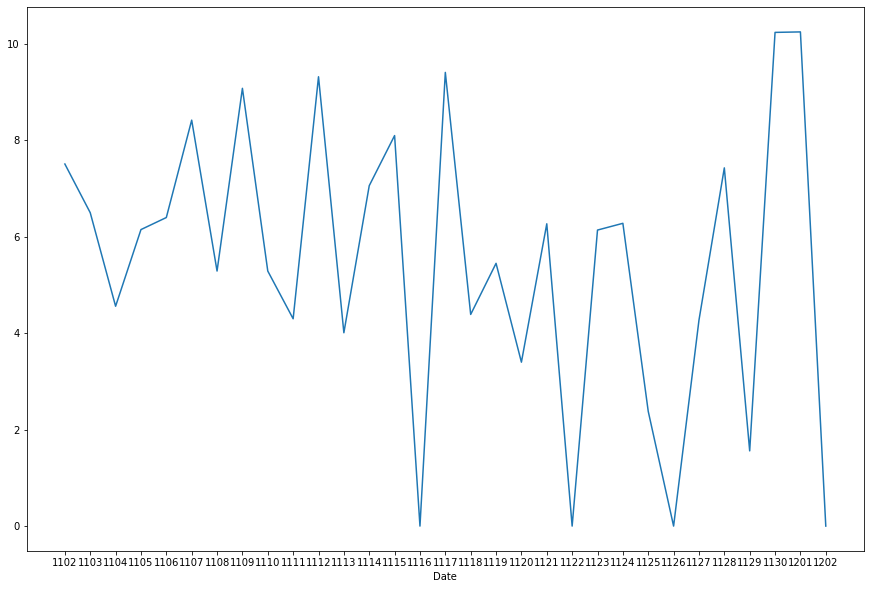

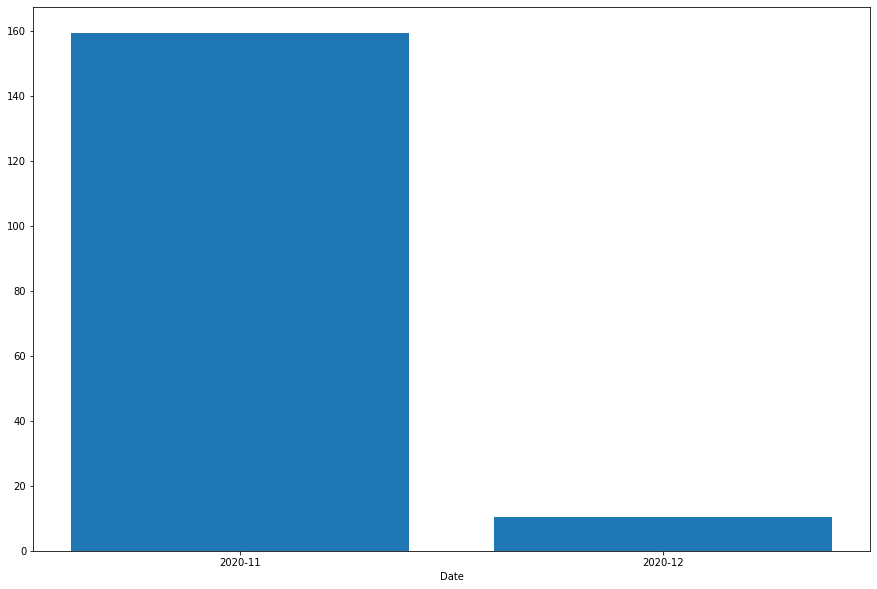

In [25]:
class PlantTimeAnalysis:
    def __init__(self, df):
        self.df = df
        self.t = Time()
    
    
    def plantTimeInDay(self, date, inSecond=False):
        """
        Get a specific day plant time in hours
        :params 
            date: a date with YYYY-MM-DD format
            inSecond: a bool to decide second or hour
        :return plantTime: a float type number
        """
        plantTime = 0  # total plant time in a day
        timeInterval1, timeInterval2, timeInterval3 = {}, {}, {} # use dict to store time interval  
        
        """
        https://blog.csdn.net/chihwei_hsu/article/details/81604455
        type 1. date in both start and end time 
        type 2. date in start time but not in end time
        type 3. date not in start time but in end time
        """        
        boolType1 = self.df['Start Time'].str.contains(date) & self.df['End Time'].str.contains(date)
        boolType2 = self.df['Start Time'].str.contains(date) & ~self.df['End Time'].str.contains(date)
        boolType3 = ~self.df['Start Time'].str.contains(date) & self.df['End Time'].str.contains(date)
        
        dfType1, dfType2, dfType3 = self.df[boolType1], self.df[boolType2], self.df[boolType3]
        
        for index, row in dfType1.iterrows():
            timeInterval1[row['Start Time'].split('.')[0]] = row['End Time'].split('.')[0]
        for index, row in dfType2.iterrows():
            nextDate = 'T'.join(str(self.t.getNearDate(row['Start Time'].split('T')[0], previous=False)).split())
            timeInterval2[row['Start Time'].split('.')[0]] = nextDate
        for index, row in dfType3.iterrows():
            previousDate = 'T'.join(str(self.t.getNearDate(row['Start Time'].split('T')[0])).split())
            timeInterval3[row['Start Time'].split('.')[0]] = previousDate
        
        # get total plant time
        for key, value in timeInterval1.items():
            plantTime += self.t.getTimeInterval(key, value)
        for key, value in timeInterval2.items():
            plantTime += self.t.getTimeInterval(key, value)
        for key, value in timeInterval2.items():
            plantTime += self.t.getTimeInterval(key, value)
            
        return plantTime if inSecond else self.t.second2hour(plantTime)
        
        
    def plantTimeInPeriod(self):
        """Plant time in a period of time"""
        plantTimeDict = {}  # a dict is used to store date and plant time 
        
        periodInDays = Time.periodDict[timePeriod]
        pastDate = self.t.getPastDate(periodInDays)
        dateList = self.t.getDateList(pastDate, Time.localDate)
        for date in dateList:
            plantTimeDict[date] = self.plantTimeInDay(date)
        return list(plantTimeDict.keys()), list(plantTimeDict.values())
    
    
    def monthlyPlantTime(self, days: list):
        """
        Get monthly plant time
        :params days: a list of days
        :returns
            list(timeDict.keys()): months
            list(timeDict.values()): monthly plant time
        """
        timeDict = {}  # use a dict to get average plant time, format with month: plantTime
        for day in days:
            plantTime = self.plantTimeInDay(day)
            month = '-'.join(day.split('-')[:-1])
            if month not in timeDict:
                timeDict[month] = plantTime
            else:
                timeDict[month] += plantTime
        return list(timeDict.keys()), list(timeDict.values())  # month, success rate
        
        
p = PlantTimeAnalysis(df)

# plantDayTime = p.plantTimeInDay('2019-01-13')  # get plant time in the specific date
# print(plantDayTime)

days, times = p.plantTimeInPeriod()
Chart.pltChart(Chart, days, times, chartType='line')

months, monthlyPlantTime = p.monthlyPlantTime(days)
Chart.pltChart(Chart, months, monthlyPlantTime, chartType='bar')

In [238]:
class TypeAnalysis:
    pass  # TODO: tree type analysis

In [239]:
class TagAnalysis:
    pass  # TODO: tag analysis